## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

In [3]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
# переведем признак pickup_datetime в тип данных datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].sort_values()

96469     2016-01-01 00:00:17
223872    2016-01-01 00:00:53
713067    2016-01-01 00:01:01
652463    2016-01-01 00:01:14
722901    2016-01-01 00:01:20
                  ...        
853710    2016-06-30 23:58:52
419031    2016-06-30 23:59:09
1008720   2016-06-30 23:59:10
405743    2016-06-30 23:59:37
500524    2016-06-30 23:59:39
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [4]:
# a)
print('Уникальные id таксопарков: ', taxi_data['vendor_id'].unique())
# б)
print('Максимальное количество пассажиров: ',taxi_data['passenger_count'].max())
# в)
print('Средняя длительность поездки в секундах: ', round(taxi_data['trip_duration'].mean()))
print('Медианная длительность поездки в секундах: ', round(taxi_data['trip_duration'].median()))
# г)
print('Минимальное время поездки в секундах: ', taxi_data['trip_duration'].min())
print('Максимальное время поездки в секундах: ', taxi_data['trip_duration'].max())

Уникальные id таксопарков:  [2 1]
Максимальное количество пассажиров:  9
Средняя длительность поездки в секундах:  959
Медианная длительность поездки в секундах:  662
Минимальное время поездки в секундах:  1
Максимальное время поездки в секундах:  3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [4]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

add_datetime_features(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [10]:
#taxi_data['pickup_datetime'].dt.date

0          2016-03-14
1          2016-06-12
2          2016-01-19
3          2016-04-06
4          2016-03-26
              ...    
1458639    2016-04-08
1458640    2016-01-10
1458641    2016-04-22
1458642    2016-01-05
1458643    2016-04-05
Name: pickup_datetime, Length: 1458644, dtype: object

In [4]:
# taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
# taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
# taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.weekday

In [5]:
#taxi_data['pickup_day_of_week'].value_counts()
print('Поездок совершено в субботу: ', len(taxi_data[taxi_data['pickup_day_of_week']=='Saturday']))

Поездок совершено в субботу:  220868


In [6]:
# среднее количество поездок в день
round(taxi_data.groupby(by = 'pickup_date')['id'].count().mean())

8015

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [6]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')
holiday_data

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


In [7]:
def add_holiday_features(tdf, hdf):
    holiday_list = list(pd.to_datetime(hdf['date'])) #обязательно к to_datetime привести

    tdf['pickup_holiday'] = tdf['pickup_date'].apply(lambda x : 1 if x in holiday_list else 0)
    return tdf

In [8]:
add_holiday_features(taxi_data, holiday_data)

C:\Users\toiri\AppData\Local\Temp\ipykernel_8848\861214947.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  tdf['pickup_holiday'] = tdf['pickup_date'].apply(lambda x : 1 if x in holiday_list else 0)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0


In [9]:
taxi_data['pickup_holiday'].value_counts()

0    1407522
1      51122
Name: pickup_holiday, dtype: int64

In [8]:
taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()

585.0

Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API.

OSRM (Open Source Routing Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет не только построить оптимальный кусочно-линейный путь из точки А в точку B, но также узнать его примерную длительность, длину, а также подробную информацию о количестве шагов, которые необходимо преодолеть по пути (количество поворотов). У данного сервиса есть API, с которым вы можете познакомиться в документации.

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью API и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из OSRM API для каждой поездки из тренировочной и тестовой выборок нашего набора данных.

Файлы с данными из OSRM для поездок из тренировочной таблицы вы можете найти здесь. Наборы данных представлены в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- id — идентификатор поездки;
- total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [10]:
osrm_data = pd.read_csv('osrm_data_train.csv')

In [11]:
def add_osrm_features(taxi_data, osrm_data):
    osrm_data_merge = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_data = taxi_data.merge(osrm_data_merge, on='id', how='left')
    return taxi_data

taxi_data = add_osrm_features(taxi_data, osrm_data)

In [13]:
# a)
print(round(taxi_data['trip_duration'].median()-taxi_data['total_travel_time'].median()))

372


In [12]:
# б) сколько строк с пропущенным значением в новой информации
taxi_data['total_travel_time'].isnull().sum()

1

В интернете можно найти множество реализаций введённых нами формул на разных языках, в том числе на Python. Мы предлагаем вам воспользоваться следующими функциями:

In [13]:
# функция для вычисления расстояния Хаверсина (в километрах)
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# функция для вычисления угла направления движения (в градусах).
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [14]:
def add_geographical_features(df):
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df

taxi_data = add_geographical_features(taxi_data)

In [15]:
round(taxi_data['haversine_distance'].median(), 2)

2.09

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

→ Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

In [16]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

Теперь, когда модель кластеризации обучена, мы можем перейти к генерации новых признаков ↓

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [17]:
def add_cluster_features(df, kmeans):
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    df['geo_cluster'] = kmeans.predict(coords)
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)

In [18]:
taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

Здесь вы можете найти набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- time — дата измерения (с интервалом в час);
- temperature — температура;
- visibility — видимость;
- wind speed — средняя скорость ветра;
- precip — количество осадков;
- events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [19]:
weather_data = pd.read_csv('weather_data.csv')
weather_data

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782,2017-01-01 21:00:00,5.0,3.3,NaN,0.43,1028.5,-6.7,16.1,ENE,7.4,0.0,0.0,None,Clear,2017-01-01,21
8783,2017-01-01 22:00:00,5.6,3.6,NaN,0.38,1029.3,-7.8,16.1,NE,9.3,0.0,0.0,None,Clear,2017-01-01,22
8784,2017-01-01 23:00:00,5.6,4.0,NaN,0.38,1030.2,-7.8,16.1,NE,7.4,0.0,0.0,None,Clear,2017-01-01,23
8785,2017-01-02 00:00:00,5.0,3.3,NaN,0.41,1030.6,-7.2,16.1,ENE,7.4,0.0,0.0,None,Clear,2017-01-02,0


In [16]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8787 non-null   object 
 1   temperature  8787 non-null   float64
 2   windchill    2295 non-null   float64
 3   heat index   815 non-null    float64
 4   humidity     8787 non-null   float64
 5   pressure     8556 non-null   float64
 6   dew Point    8787 non-null   float64
 7   visibility   8787 non-null   float64
 8   wind dir     8787 non-null   object 
 9   wind speed   8787 non-null   float64
 10  gust speed   8787 non-null   float64
 11  precip       8787 non-null   float64
 12  events       8787 non-null   object 
 13  conditions   8787 non-null   object 
 14  date         8787 non-null   object 
 15  hour         8787 non-null   int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 1.1+ MB


In [20]:
def add_weather_features(tdf, wdf):
    # вначале удалю ненужные по заданию столбцы
    wdf.drop(['windchill', 'heat index','humidity', 'pressure', 'dew Point', 'wind dir', 'gust speed', 'conditions', 'date', 'hour'], axis=1, inplace=True)
    wdf['date'] = pd.to_datetime(wdf['time']).dt.date
    wdf['hour'] = pd.to_datetime(wdf['time']).dt.hour
    #wdf.drop(['time'], axis=1, inplace=True)
    
    tdf = pd.merge(tdf, wdf,
                    how='left',
                    left_on=['pickup_date','pickup_hour'],
                    right_on = ['date','hour'])
    tdf = tdf.drop(['time', 'date','hour'], axis=1)
    return tdf

taxi_data = add_weather_features(taxi_data, weather_data)

In [20]:
# посмотреть какие погодные условия есть вообще и есть ли среди них Снег
weather_data['events'].value_counts()

None    8332
Rain     379
Snow      74
Fog        2
Name: events, dtype: int64

In [21]:
# сколько поездок было совершенно в снежную погоду
taxi_data[taxi_data['events']=='Snow']['id'].count()

13126

In [22]:
print(taxi_data['events'].value_counts()['Snow'])

13126


In [23]:
# Какую долю (в процентах) в общем количестве наблюдений в таблице с данными о поездках 
# занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.
#taxi_data['events'].value_counts(normalize=True)
print(np.round(taxi_data.isnull().sum().max() / taxi_data.shape[0] * 100, 2))

0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [22]:
def fill_null_weather_data(df):
  df[['temperature', 'visibility', 'wind speed', 'precip']] = df[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
    df.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
  df['events'] = df['events'].fillna('None')
  df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
  df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
  df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())

  return df

taxi_data = fill_null_weather_data(taxi_data)

In [23]:
round(taxi_data['temperature'].median(), 1)

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


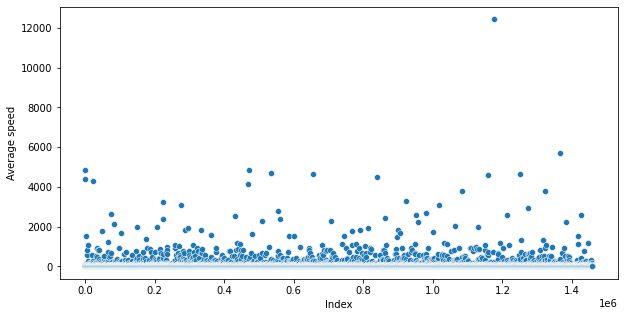

In [24]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [48]:
#taxi_data_copy = taxi_data.copy()
#taxi_data = taxi_data_copy.copy()

In [25]:
# a) найдем поездки, длительность которых превышает 24 часа (а у нас в табл секунды, значит 24*60*60 = 86400)
# taxi_data[taxi_data['trip_duration']>86400] # посмотреть на строки
print('Количество поездок, длительность которых превышала 24 часа: ', len(taxi_data[taxi_data['trip_duration']>86400]))
# удалим найденные выше строки. присвоением. поменять условие!
taxi_data = taxi_data[taxi_data['trip_duration']<86400]

Количество поездок, длительность которых превышала 24 часа:  4


In [27]:
# б) Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч 
# taxi_data[avg_speed>300 # посмотреть на строки
print('Количество поездок, средн скор кот выше 300 км/ч: ', len(taxi_data[avg_speed>300]))
# удалим их. перезапишем датафрейм с (!)противоположным условием
taxi_data = taxi_data[avg_speed<300]

C:\Users\toiri\AppData\Local\Temp\ipykernel_8848\1267366618.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Количество поездок, средн скор кот выше 300 км/ч: ', len(taxi_data[avg_speed>300]))
C:\Users\toiri\AppData\Local\Temp\ipykernel_8848\1267366618.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_data = taxi_data[avg_speed<300]


Количество поездок, средн скор кот выше 300 км/ч:  0


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [28]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

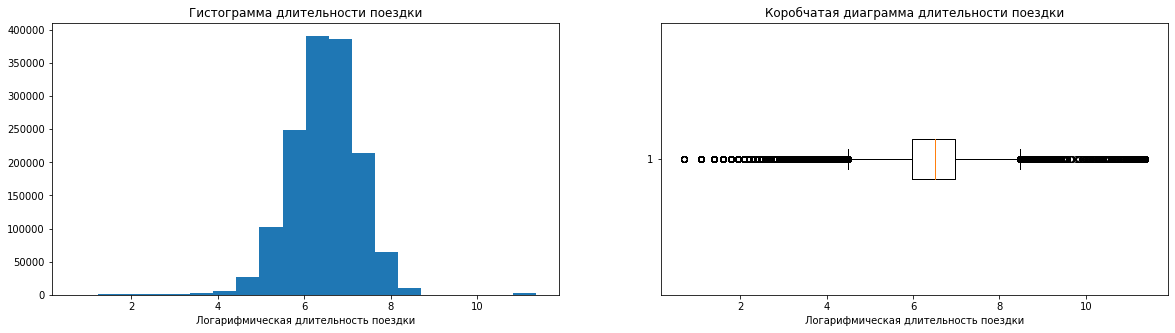

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

#гистограмма
axes[0].hist(x=taxi_data['trip_duration_log'], label=['Длительность поездки'], bins = 20)
axes[0].set_xlabel('Логарифмическая длительность поездки')
axes[0].set_title('Гистограмма длительности поездки');

#коробчатая
axes[1].boxplot(x=taxi_data['trip_duration_log'], vert=False)
axes[1].set_xlabel('Логарифмическая длительность поездки')
axes[1].set_title('Коробчатая диаграмма длительности поездки');

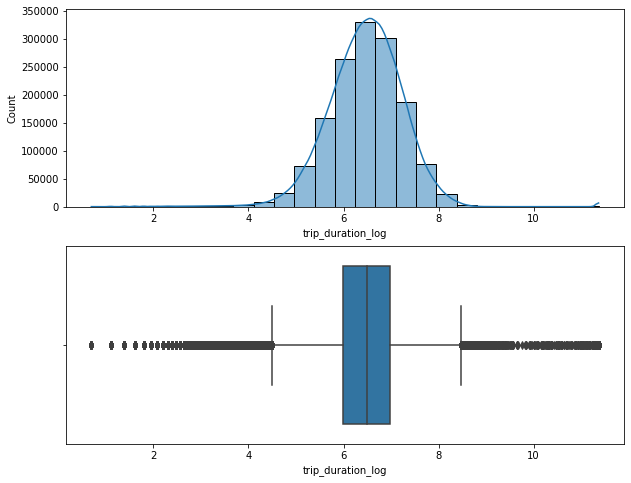

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    ax=axes[0]
);
#axes[0].set_title('Гистограмма длительности поездки', fontsize=16)
sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    #y='country',
    orient='h',
    ax=axes[1]
);
#axes[1].set_title('Коробчатая диаграмма длительности поездки', fontsize=16);

In [31]:
# из визуализации данное распределение является нормальным.

# Проверим гипотезу с помощью теста Д’Агостино-Пирсона (scipy.stats.normaltest) при уровне значимости alpha = 0.05
stat, p = stats.normaltest(taxi_data['trip_duration_log'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=138350.166, p-value=0.000
Отклонить гипотезу о нормальности


<function matplotlib.pyplot.show(close=None, block=None)>

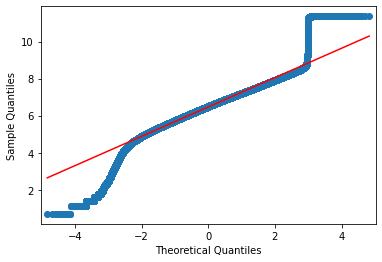

In [71]:
# на этом графике тоже как-то можно увидеть ненормальное распределение
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(taxi_data.trip_duration_log, line='s')
pyplot.show

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

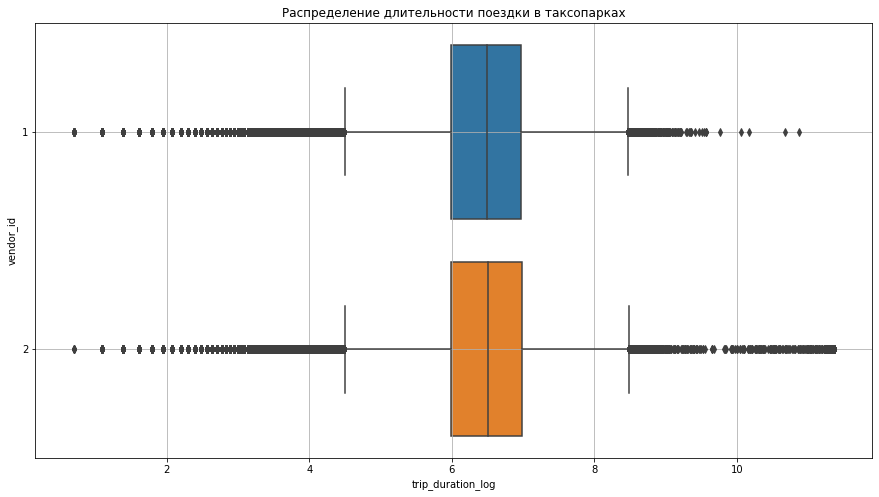

In [49]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=taxi_data, y='vendor_id', x='trip_duration_log', orient='h')
plt.title('Распределение длительности поездки в таксопарках')
plt.grid()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

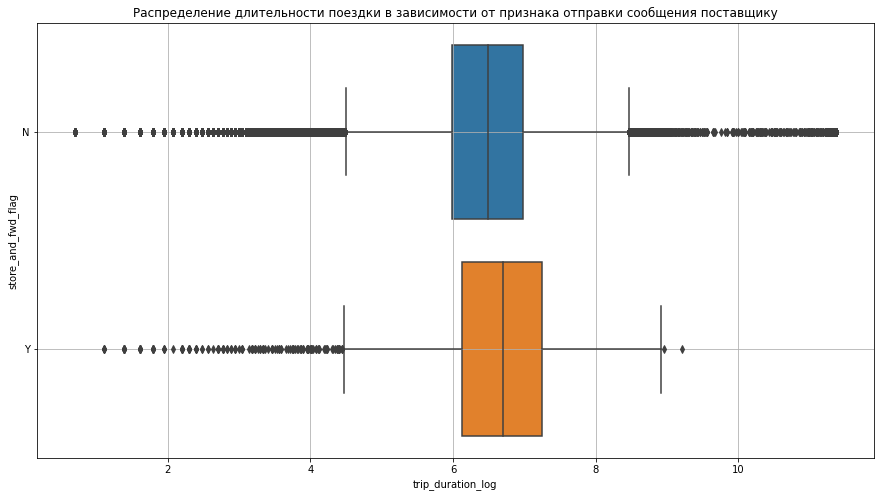

In [50]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=taxi_data, x='trip_duration_log', y='store_and_fwd_flag', orient='h')
plt.title('Распределение длительности поездки в зависимости от признака отправки сообщения поставщику')
plt.grid();

Примечание. Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

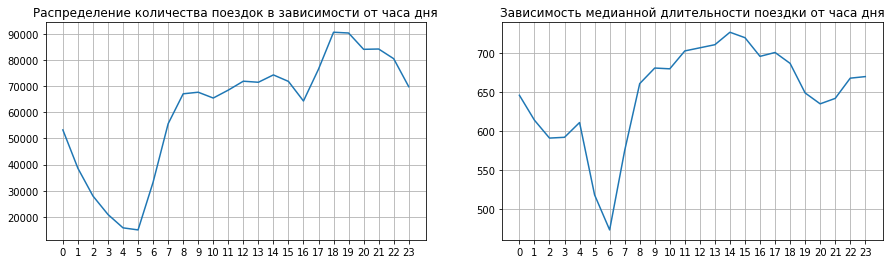

In [32]:
trip_quantity_per_hour = taxi_data.groupby('pickup_hour')['id'].count()
median_duration_per_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

axes[0].plot(trip_quantity_per_hour)
axes[0].set_title('Распределение количества поездок в зависимости от часа дня')
axes[0].grid()
#axes[0].set_xlabel('Часы')
#axes[0].set_ylabel('Количество поездок')
axes[0].set_xticks(range(0,24, 1));

axes[1].plot(median_duration_per_hour)
axes[1].set_title('Зависимость медианной длительности поездки от часа дня')
axes[1].grid()
#axes[1].set_xlabel('Часы')
#axes[1].set_ylabel('Медианная длительность')
axes[1].set_xticks(range(0,24, 1));

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


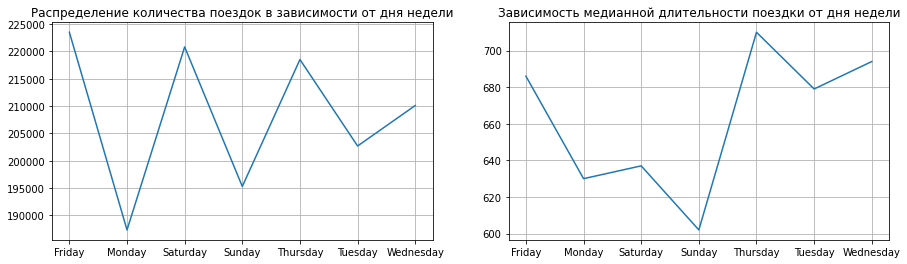

In [33]:
trip_quantity_per_day = taxi_data.groupby('pickup_day_of_week')['id'].count()
median_duration_per_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

axes[0].plot(trip_quantity_per_day)
axes[0].set_title('Распределение количества поездок в зависимости от дня недели')
axes[0].grid()
#axes[0].set_xlabel('Дни недели')
#axes[0].set_ylabel('Количество поездок')
#axes[0].set_xticks(range(0, 7, 1));

axes[1].plot(median_duration_per_day)
axes[1].set_title('Зависимость медианной длительности поездки от дня недели')
axes[1].grid()
#axes[1].set_xlabel('Дни недели')
#axes[1].set_ylabel('Медианная длительность')
#axes[1].set_xticks(range(0, 7, 1));

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

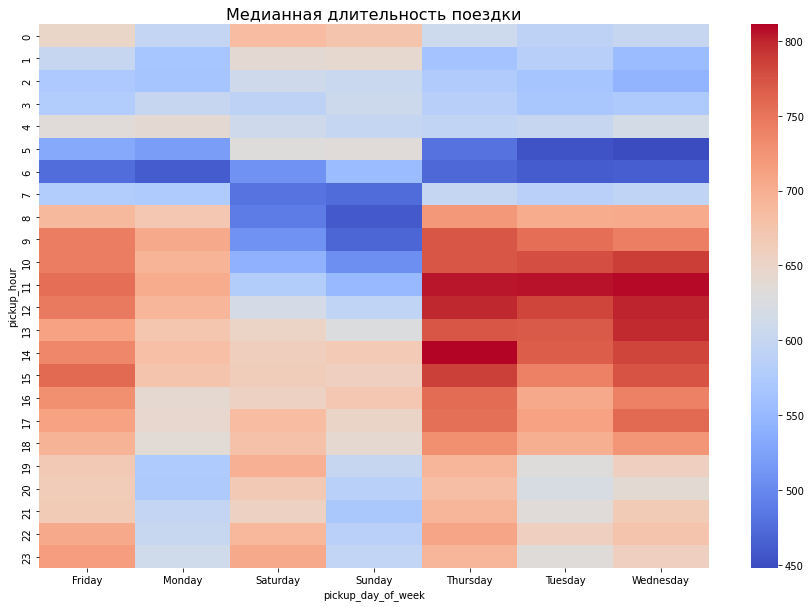

In [34]:
pivot = taxi_data.pivot_table(
    values='trip_duration',
    columns='pickup_day_of_week',
    index='pickup_hour',
    aggfunc='median'
)
fig, ax = plt.subplots(figsize=(15, 10))
heatmap = sns.heatmap(data=pivot, cmap='coolwarm', xticklabels=True, yticklabels=True)
heatmap.set_title('Медианная длительность поездки', fontsize=16);

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [ ]:
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)

# plt.figure(figsize=(10, 8))
# sn1 = sns.scatterplot(data = taxi_data, x = 'pickup_longitude', y = 'pickup_latitude', hue='geo_cluster', s=1, palette='bright')
# sn1.set_xlim(city_long_border)  # <-- оказалось, что эти ограничения не ограничивают. надо прям в данных ограничивать. см. ниже
# sn1.set_ylim(city_lat_border)
# sn1.set_title('Диаграмма рассеивания начала поездок')

(40.63, 40.85)

C:\Users\toiri\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


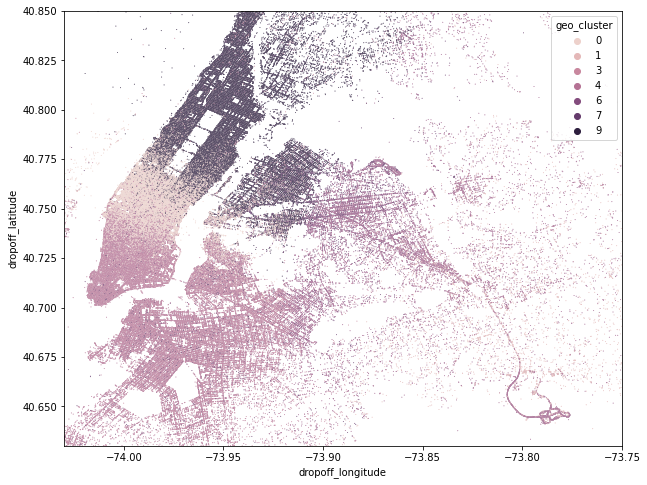

In [70]:
# plt.figure(figsize=(10, 8))
# sn2 = sns.scatterplot(data = taxi_data, x = 'dropoff_longitude', y = 'dropoff_latitude', hue='geo_cluster', s=1) # <-- а тут надо palette='bright' - потому 
# что без яркой палитры просто не все кластеры выводились. и казалось, что set_xlim и set_ylim ограничивают 
# sn2.set_xlim(city_long_border)
# sn2.set_ylim(city_lat_border)

ответ не сходится. у меня отсутствует 3 кластера в этом огрничении, а на платформе - 2.

In [35]:
# всего кластеров 10. сгруппируем
taxi_data.groupby(by='geo_cluster').count()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,temperature,visibility,wind speed,precip,events,trip_duration_log
geo_cluster,,,,,,,,,,,,,,,,,,,,,
0,596367,596367,596367,596367,596367,596367,596367,596367,596367,596367,...,596367,596367,596367,596367,596367,596367,596367,596367,596367,596367
1,7124,7124,7124,7124,7124,7124,7124,7124,7124,7124,...,7124,7124,7124,7124,7124,7124,7124,7124,7124,7124
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,27014,27014,27014,27014,27014,27014,27014,27014,27014,27014,...,27014,27014,27014,27014,27014,27014,27014,27014,27014,27014
4,359164,359164,359164,359164,359164,359164,359164,359164,359164,359164,...,359164,359164,359164,359164,359164,359164,359164,359164,359164,359164
5,43615,43615,43615,43615,43615,43615,43615,43615,43615,43615,...,43615,43615,43615,43615,43615,43615,43615,43615,43615,43615
6,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
7,41152,41152,41152,41152,41152,41152,41152,41152,41152,41152,...,41152,41152,41152,41152,41152,41152,41152,41152,41152,41152
8,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [36]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# сформируем данные с заданными ограничениями
df_for_pickup = taxi_data[(taxi_data['pickup_longitude'].between(city_long_border[0], city_long_border[1]))&(taxi_data['pickup_latitude'].between(city_lat_border[0], city_lat_border[1]))]
df_for_dropoff = taxi_data[(taxi_data['dropoff_longitude'].between(city_long_border[0], city_long_border[1]))&(taxi_data['dropoff_latitude'].between(city_lat_border[0], city_lat_border[1]))]
# а применив ограничение, видим, что нехватает 2 класстера, а не 3! как было на scatterplot
df_for_pickup.groupby(by='geo_cluster').count()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,temperature,visibility,wind speed,precip,events,trip_duration_log
geo_cluster,,,,,,,,,,,,,,,,,,,,,
0,596316,596316,596316,596316,596316,596316,596316,596316,596316,596316,...,596316,596316,596316,596316,596316,596316,596316,596316,596316,596316
1,6932,6932,6932,6932,6932,6932,6932,6932,6932,6932,...,6932,6932,6932,6932,6932,6932,6932,6932,6932,6932
3,26990,26990,26990,26990,26990,26990,26990,26990,26990,26990,...,26990,26990,26990,26990,26990,26990,26990,26990,26990,26990
4,358401,358401,358401,358401,358401,358401,358401,358401,358401,358401,...,358401,358401,358401,358401,358401,358401,358401,358401,358401,358401
5,43579,43579,43579,43579,43579,43579,43579,43579,43579,43579,...,43579,43579,43579,43579,43579,43579,43579,43579,43579,43579
6,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
7,40994,40994,40994,40994,40994,40994,40994,40994,40994,40994,...,40994,40994,40994,40994,40994,40994,40994,40994,40994,40994
9,382989,382989,382989,382989,382989,382989,382989,382989,382989,382989,...,382989,382989,382989,382989,382989,382989,382989,382989,382989,382989


In [37]:
# а тут все также 3 кластера не хватает
df_for_dropoff.groupby(by='geo_cluster').count()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,temperature,visibility,wind speed,precip,events,trip_duration_log
geo_cluster,,,,,,,,,,,,,,,,,,,,,
0,596147,596147,596147,596147,596147,596147,596147,596147,596147,596147,...,596147,596147,596147,596147,596147,596147,596147,596147,596147,596147
1,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,...,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606
3,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,...,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560
4,352615,352615,352615,352615,352615,352615,352615,352615,352615,352615,...,352615,352615,352615,352615,352615,352615,352615,352615,352615,352615
5,42810,42810,42810,42810,42810,42810,42810,42810,42810,42810,...,42810,42810,42810,42810,42810,42810,42810,42810,42810,42810
7,40229,40229,40229,40229,40229,40229,40229,40229,40229,40229,...,40229,40229,40229,40229,40229,40229,40229,40229,40229,40229
9,376429,376429,376429,376429,376429,376429,376429,376429,376429,376429,...,376429,376429,376429,376429,376429,376429,376429,376429,376429,376429


C:\Users\toiri\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


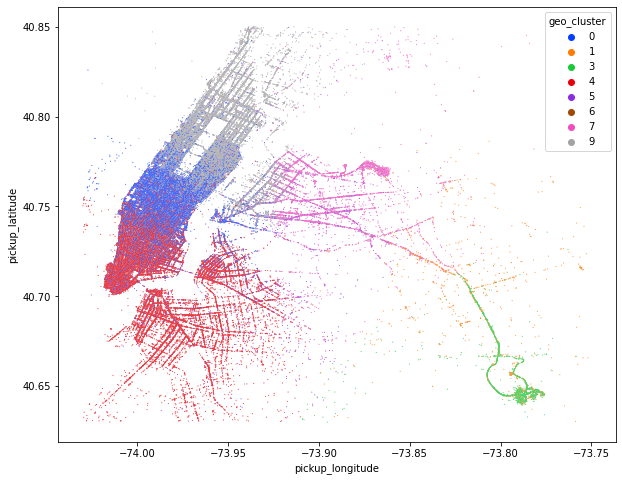

In [84]:
plt.figure(figsize=(10, 8))
sn1 = sns.scatterplot(data = df_for_pickup, x = 'pickup_longitude', y = 'pickup_latitude', hue='geo_cluster', s=1, palette='bright')

C:\Users\toiri\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


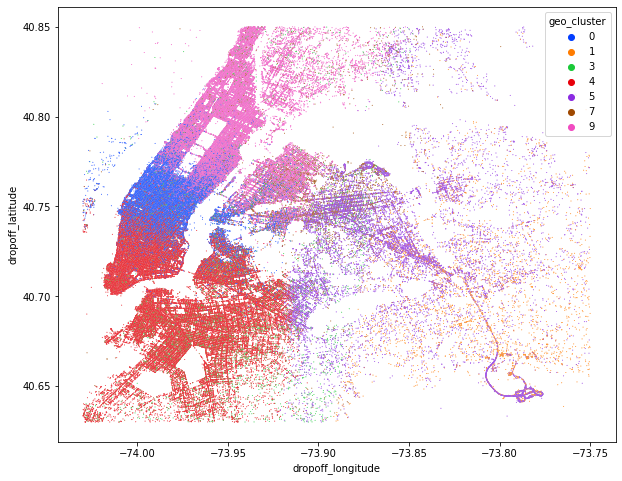

In [96]:
plt.figure(figsize=(10, 8))
sn2 = sns.scatterplot(data = df_for_dropoff, x = 'dropoff_longitude', y = 'dropoff_latitude', hue='geo_cluster', s=1, palette='bright')

На графике sn1 не хватает 2 кластера (отображаются 8), на графике sn2 не хватает 3 кластера (отображаются 7). Поэтому ниже я расчитаю extra_cluster

In [86]:
extra_cluster = taxi_data['geo_cluster'].nunique()-len(set(
    df_for_pickup['geo_cluster'].value_counts().index.sort_values().tolist() + 
    df_for_dropoff['geo_cluster'].value_counts().index.sort_values().tolist()
))
print('На диаграмму не попало {} кластеров'.format(extra_cluster))

На диаграмму не попало 2 кластеров


In [91]:
set(df_for_pickup['geo_cluster'].value_counts().index.sort_values().tolist() + df_for_dropoff['geo_cluster'].value_counts().index.sort_values().tolist())

{0, 1, 3, 4, 5, 6, 7, 9}

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [38]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))
# должно быть Shape of data: (1458233, 27)
# Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
#        'passenger_count', 'pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
#        'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
#        'pickup_holiday', 'total_distance', 'total_travel_time',
#        'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
#        'temperature', 'visibility', 'wind speed', 'precip', 'events',
#        'trip_duration_log'],
#       dtype='object')

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [40]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [41]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
print('В таблице осталось {} столбцов'.format(train_data.shape[1]))

В таблице осталось 25 столбцов


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [42]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

- vendor_id;
- store_and_fwd_flag;
- pickup_day_of_week;
- geo_cluster;
- events.

Первые два (vendor_id и store_and_fwd_flag) из них являются бинарными (имеют два уникальных значения). Давайте их закодируем ↓

### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [43]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

print('Среднее по закодированному столбцу vendor_id = {}'.format(round(train_data['vendor_id'].mean(), 2)))
print('Среднее по закодированному столбцу store_and_fwd_flag = {}'.format(round(train_data['store_and_fwd_flag'].mean(), 3)))

Среднее по закодированному столбцу vendor_id = 0.53
Среднее по закодированному столбцу store_and_fwd_flag = 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [44]:
from sklearn.preprocessing import OneHotEncoder
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = OneHotEncoder(drop='first')
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print('С помощью однократного кодирования у нас получилось сгенерировать {} признаков'.format(data_onehot.shape[1]))

С помощью однократного кодирования у нас получилось сгенерировать 18 признаков


Добавим полученную таблицу с закодированными признаками:

In [45]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))
# Shape of data: (1458233, 38)

Shape of data: (1458233, 38)


In [35]:
# выгружу csv с данными
train_data.to_csv('taxi_train_data.csv', index=False)

In [2]:
# и загружу, когда надо, чтобы не делать все верхние шаги заново
train_data = pd.read_csv('taxi_train_data.csv')

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [46]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать hold-out-валидацию. Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и времязатратным.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [47]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

Примечание. Тестовая выборка, с которой мы познакомимся позднее, представлена отдельным датасетом. Истинные длительности поездок из тестового набора являются для нас неизвестными, и финальное качество модели можно узнать, только сделав предсказание и отправив файл с предсказанием на проверку на платформе Kaggle.

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [48]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
print(selector.get_feature_names_out())

X_train = X_train[selector.get_feature_names_out()]
X_valid = X_valid[selector.get_feature_names_out()]

['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_3'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


In [49]:
best_features = selector.get_feature_names_out()
best_features

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


Примечание. Есть разные варианты масштабирования. Мы будем использовать min-max-нормализацию. Помните, что нормализация требуется для предикторов, а не для целевой переменной.

### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [50]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler().fit(X_train)
X_train_scaler = mm_scaler.fit_transform(X_train)
X_valid_scaler = mm_scaler.transform(X_valid)
print('Среднее арифметическое для первого предиктора из валидационной выборки равно {}'.format(round(X_valid_scaler[:,0].mean(),2)))
X_valid_scaler[:,0].mean()

Среднее арифметическое для первого предиктора из валидационной выборки равно 0.54


0.5354341180797852

In [51]:
type(X_train_scaler)

numpy.ndarray

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Для начала воспользуемся самой простой моделью регрессии, которая нам известна — классическая линейная регрессия по методу OLS ↓

### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [53]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaler, y_train_log)
y_train_log_pred = lr.predict(X_train_scaler)
y_valid_log_pred = lr.predict(X_valid_scaler)

print('RMSLE на train data {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE на validation data {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE на train data 0.54
RMSLE на validation data 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [54]:
# создаем генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaler)
# генерируем полиномиальные признаки для тренирововчной выборки
X_train_poly = poly.transform(X_train_scaler)
# генерируем полиномиальные признаки для валидационной выборки
X_valid_poly = poly.transform(X_valid_scaler)

# посморим, какие получились размерности
X_train_poly.shape, X_valid_poly.shape

((977016, 350), (481217, 350))

In [55]:
# создаем объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
# обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train_log)
# делаем предсказание для тренировочной выборки
X_train_poly_pred = lr_model_poly.predict(X_train_poly)
# делаем предсказание для валидационной выборки
X_valid_poly_pred = lr_model_poly.predict(X_valid_poly)

In [58]:
print('RMSE для тренировочной выборки на полиномиальных признаках = ', np.sqrt(metrics.mean_squared_error(y_train_log, X_train_poly_pred)))
print('RMSE для валидационной выборки на полиномиальных признаках = ', np.sqrt(metrics.mean_squared_error(y_valid_log, X_valid_poly_pred)))

RMSE для тренировочной выборки на полиномиальных признаках =  0.4663751182592895
RMSE для валидационной выборки на полиномиальных признаках =  0.700389146732794


Чтобы исправить проблему переобучения, попробуем воспользоваться регуляризацией ↓

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [60]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Обучаем модель
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
X_train_poly_l2_pred = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
X_valid_poly_l2_pred = ridge_lr_poly.predict(X_valid_poly)

In [61]:
print('RMSE для train на полиномиальных признаках с L2-рег = ', np.sqrt(metrics.mean_squared_error(y_train_log, X_train_poly_l2_pred)))
print('RMSE для valid на полиномиальных признаках c L2-рег = ', np.sqrt(metrics.mean_squared_error(y_valid_log, X_valid_poly_l2_pred)))

RMSE для train на полиномиальных признаках с L2-рег =  0.47705458974756443
RMSE для valid на полиномиальных признаках c L2-рег =  0.4805061821588233


Еще одной из простейших моделей, которой мы попробуем воспользоваться, будет дерево решений ↓

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию, но задайте значение параметра random_state = 42.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [7]:
#Создаём объект класса DecisionTreeRegressor
dec_tree_regr = tree.DecisionTreeRegressor(random_state=42) #генератор случайных чисел

#Обучаем дерево решений
dec_tree_regr.fit(X_train_scaler, y_train_log) # тут надо на X_train_scaler, а не на X_train_poly!

# делаем предсказание
X_train_scaler_tree_pred = dec_tree_regr.predict(X_train_scaler)
X_valid_scaler_tree_pred = dec_tree_regr.predict(X_valid_scaler)

In [83]:
print('RMSLE для train для DecisionTreeRegressor = ', np.sqrt(metrics.mean_squared_error(y_train_log, X_train_scaler_tree_pred)))
print('RMSLE для valid для DecisionTreeRegressor = ', np.sqrt(metrics.mean_squared_error(y_valid_log, X_valid_scaler_tree_pred)))

RMSLE для train для DecisionTreeRegressor =  0.0030491915836393033
RMSLE для valid для DecisionTreeRegressor =  0.5657741227751728


Мы знаем, что обучение дерева решений без ограничения его глубины практически всегда приводит к переобучению. Давайте попробуем подобрать оптимальную глубину дерева ↓

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [11]:
def max_depth_selection(X, y, X_v, y_v):
    rmsle_train = {}
    rmsle_valid = {}
    for i in range(7, 20, 1):
        dtr=tree.DecisionTreeRegressor(max_depth=i, random_state=42)
        dtr.fit(X, y)
        y_train_predict_dtr=dtr.predict(X)
        y_valid_predict_dtr=dtr.predict(X_v)
        rmsle_train[i] = np.sqrt(metrics.mean_squared_error(y, y_train_predict_dtr))
        rmsle_valid[i] = np.sqrt(metrics.mean_squared_error(y_v, y_valid_predict_dtr))
    return rmsle_train, rmsle_valid

rmsle_train, rmsle_valid = max_depth_selection(X_train_scaler, y_train_log, X_valid_scaler, y_valid_log)

In [81]:
rmsle_valid

{7: 0.44717395454940917,
 8: 0.4408168194087142,
 9: 0.4359366572745868,
 10: 0.43167244913420333,
 11: 0.4304259909562737,
 12: 0.4297969269498582,
 13: 0.433561061749575,
 14: 0.4392491613647613,
 15: 0.4462344142828774,
 16: 0.4522689829612981,
 17: 0.4626317620288282,
 18: 0.471751801596489,
 19: 0.48236749556197656}

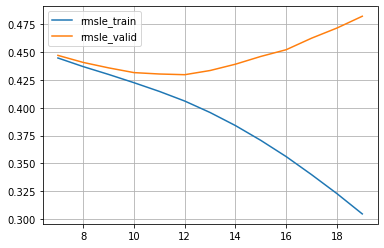

In [79]:
plt.plot(list(rmsle_train.keys()), list(rmsle_train.values()))
plt.plot(list(rmsle_valid.keys()), list(rmsle_valid.values()))
plt.grid()
plt.legend(('rmsle_train', 'rmsle_valid'));

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

Примечание. Обучение ансамблевых методов на таком большом объёме данных может занимать немало времени (до нескольких десятков минут), поэтому будьте особенно внимательны: при выполнении заданий и перед запуском обучения убедитесь в том, что вы выполнили все заданные условия.

Также советуем заварить чай и найти расслабляющее видео, чтобы приятно скоротать время в ожидании обучения ваших моделей.

Ещё один лайфхак: при желании вы можете установить параметр verbose=True, чтобы отображать процесс обучения моделей и понимать, сколько времени осталось до конца обучения.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [84]:
rfr=ensemble.RandomForestRegressor(n_estimators=200,
                                   max_depth=12,
                                   criterion='squared_error',
                                   min_samples_split=20,
                                   random_state=42,
                                   verbose=True # отображает процесс обучения моделей для понимания, сколько времени осталось до конца обучения
                                   )
rfr.fit(X_train_scaler, y_train_log)
X_train_rfr_pred=rfr.predict(X_train_scaler)
X_valid_rfr_pred=rfr.predict(X_valid_scaler)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 46.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   41.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.3s finished


In [85]:
print('RMSLE для train для RandomForestRegressor = ', np.sqrt(metrics.mean_squared_error(y_train_log, X_train_rfr_pred)))
print('RMSLE для valid для RandomForestRegressor = ', np.sqrt(metrics.mean_squared_error(y_valid_log, X_valid_rfr_pred)))

RMSLE для train для RandomForestRegressor =  0.39925177829332953
RMSLE для valid для RandomForestRegressor =  0.4141147852298324


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Посмотрим, что будет при последовательном ансамблировании ↓

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [55]:
gb = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                        n_estimators = 100,
                                        max_depth = 6,
                                        min_samples_split = 30,
                                        random_state = 42,
                                        verbose=True) # отображает процесс обучения моделей для понимания, сколько времени осталось до конца обучения
gb.fit(X_train_scaler, y_train_log)

gb_train_pred  = gb.predict(X_train_scaler)
gb_valid_pred  = gb.predict(X_valid_scaler)

      Iter       Train Loss   Remaining Time 
         1           0.3110           17.57m
         2           0.2247           17.06m
         3           0.1987           16.51m
         4           0.1875           16.66m
         5           0.1821           16.56m
         6           0.1789           16.64m
         7           0.1742           16.40m
         8           0.1721           16.40m
         9           0.1705           16.27m
        10           0.1694           16.35m
        20           0.1585           15.26m
        30           0.1532           13.27m
        40           0.1500           11.42m
        50           0.1468            9.59m
        60           0.1439            7.73m
        70           0.1421            5.76m
        80           0.1402            3.87m
        90           0.1383            1.95m
       100           0.1371            0.00s


In [57]:
print('RMSLE для train для GradientBoostingRegressor = ', np.sqrt(metrics.mean_squared_error(y_train_log, gb_train_pred)))
print('RMSLE для valid для GradientBoostingRegressor = ', np.sqrt(metrics.mean_squared_error(y_valid_log, gb_valid_pred)))

RMSLE для train для GradientBoostingRegressor =  0.370280141889469
RMSLE для valid для GradientBoostingRegressor =  0.3925414670444254


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Это был - Градиентный бустинг над деревьями решений.

Теперь давайте посмотрим на важность факторов для наилучшей ансамблевой модели ↓

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


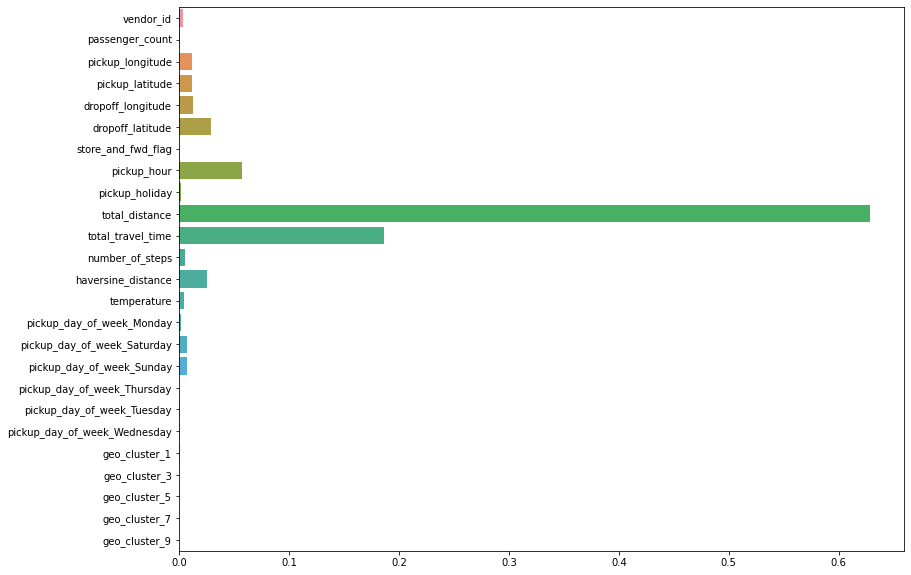

In [92]:
fig, ax = plt.subplots(figsize=(13, 10))
feature = X_train.columns
feature_importances = gb.feature_importances_
sns.barplot(y=feature, x=feature_importances, ax=ax);

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Нам хотелось бы понять, насколько наша итоговая модель хорошо предсказывает целевой признак с точки зрения бизнес-процесса. Точнее, мы бы хотели получить более понятное представление об ошибке прогноза длительности поездки.

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.
Не забудьте перевести целевую переменную и предсказания вашей модели из логарифмического масштаба в изначальный, воспользовавшись формулой:

In [58]:
y_valid_exp = np.exp(y_valid_log)-1
gb_valid_pred_exp = np.exp(gb_valid_pred)-1
print(round(metrics.median_absolute_error(y_valid_exp, gb_valid_pred_exp)/60, 1)) # делим на 60 - это переводим в минуты, как в задании
metrics.median_absolute_error(y_valid_exp, gb_valid_pred_exp)/60

1.8


1.830519527102812

## Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [51]:
test_data = pd.read_csv("test.csv")
osrm_data_test = pd.read_csv("osrm_data_test.csv")
test_id = test_data['id']

In [52]:
# и эту табл заново выгрузим, т.к. выше удаляли из нее столбцы и ниже неправильно отработает функция
weather_data = pd.read_csv('weather_data.csv')

In [56]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id                            625134 non-null  object        
 1   vendor_id                     625134 non-null  int64         
 2   pickup_datetime               625134 non-null  datetime64[ns]
 3   passenger_count               625134 non-null  int64         
 4   pickup_longitude              625134 non-null  float64       
 5   pickup_latitude               625134 non-null  float64       
 6   dropoff_longitude             625134 non-null  float64       
 7   dropoff_latitude              625134 non-null  float64       
 8   store_and_fwd_flag            625134 non-null  int64         
 9   pickup_date                   625134 non-null  object        
 10  pickup_hour                   625134 non-null  int64         
 11  pickup_holida

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [53]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))
# Shape of data: (625134, 25)

C:\Users\toiri\AppData\Local\Temp\ipykernel_8848\861214947.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  tdf['pickup_holiday'] = tdf['pickup_date'].apply(lambda x : 1 if x in holiday_list else 0)


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$


In [60]:
# ну и сделаем предсказание для X_test_scaled выборки с помощью GradientBoostingRegressor - градиентного бустинга над деревьями решений
test_gb_pred  = gb.predict(X_test_scaled)

In [66]:
# переведем предсказания из логарифмического масштаба в истинный
y_test_pred = np.exp(test_gb_pred)-1

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:

In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('data/submission_gb.csv', index=False)

Совет. Не останавливайтесь на полученном решении этой задачи. Это лишь один из возможных вариантов. Вы можете попробовать улучшить качество предсказания, используя более продвинутые подходы для генерации признаков, обработки пропусков, поиска выбросов, отбора признаков и так далее. 

Поэкспериментируйте с методами оптимизации гиперпараметров алгоритмов. Но будьте осторожны, так как в обучающем наборе очень много данных и подбор внешних параметров может занимать много времени. Выбирайте диапазоны оптимизации с умом.

Вы также можете воспользоваться более сложными методами машинного обучения, например современными вариантами бустинга, такими как CatBoost от Яндекса или LightGBM от Microsoft.

Можно даже использовать стекинг, агрегировав несколько мощных моделей в одну.

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: 
- повышенная производительность путем параллелизации процесса обучения, 
- повышенное качество решения за счет усовершенствования алгоритма бустинга, 
- меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaler, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaler, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)